In [11]:
from util import setup_notebook
setup_notebook()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from testmining.apfd import read_tests

In [54]:
#df = read_tests('../output/square@okhttp/experimental/okhttp@optimal-failure.csv')
df = read_tests('../output/Graylog2@graylog2-server/experimental/graylog2-server@optimal-failure.csv')

In [55]:
df.head()

,travisBuildNumber,travisBuildId,travisJobId,testName,index,duration,count,failures,errors,skipped,red
0,8,1106258,1106259,org.graylog2.inputs.gelf.GELFProcessorTest,0,0.014,2,1,1,0,2
1,8,1106258,1106259,org.graylog2.streams.matchers.AdditionalFieldM...,1,0.057,1,0,0,0,0
2,8,1106258,1106259,org.graylog2.streams.matchers.HostMatcherTest,2,0.004,1,0,0,0,0
3,8,1106258,1106259,org.graylog2.streams.matchers.SeverityOrHigher...,3,0.002,1,0,0,0,0
4,8,1106258,1106259,org.graylog2.streams.StreamCacheTest,4,0.130,2,0,0,0,0


In [78]:
from functools import partial

def red_percent_budget(budget, job):
    faults = job['red'].sum()
    spent = job['duration'].cumsum()
    executed = spent < budget
    found = job[executed]['red'].sum()
    return (found / faults) * 100

def faults_detected(tests, budget):
    return tests.groupby('travisJobId').apply(partial(red_percent_budget, budget)).rename(budget)

In [57]:
import altair as alt

In [88]:
import numpy as np

def allocate_budgets(tests, fac=1.1):

    def red_duration(job):
        return job[job['red'] > 0]['duration'].sum()

    max_duration = tests.groupby('travisJobId').apply(red_duration).max()
    log = np.log(max_duration) / np.log(fac)
    return np.append(0, np.power(fac, np.arange(0, np.ceil(log) + 1)))

In [89]:
allocate_budgets(df)

array([ 0.        ,  1.        ,  1.1       ,  1.21      ,  1.331     ,
        1.4641    ,  1.61051   ,  1.771561  ,  1.9487171 ,  2.14358881,
        2.35794769,  2.59374246,  2.85311671,  3.13842838,  3.45227121,
        3.79749834,  4.17724817,  4.59497299,  5.05447028,  5.55991731,
        6.11590904,  6.72749995,  7.40024994,  8.14027494,  8.95430243,
        9.84973268, 10.83470594, 11.91817654, 13.10999419, 14.42099361,
       15.86309297, 17.44940227, 19.1943425 ])

In [79]:
#dx = [faults_detected(df, budget) for budget in range(0, 31, 1)]
dx = [faults_detected(df, budget) for budget in allocate_budgets(df)]

In [80]:
import pandas as pd

dy = pd.concat(dx, axis=1)
dy.head()

,1.0,1.1,1.2100000000000002,1.3310000000000004,1.4641000000000004,1.6105100000000006,1.7715610000000008,1.9487171000000012,2.1435888100000016,2.357947691000002,...,8.14027493868399,8.95430243255239,9.84973267580763,10.834705943388395,11.918176537727234,13.10999419149996,14.420993610649957,15.863092971714952,17.44940226888645,19.194342495775096
travisJobId,,,,,,,,,,,,,,,,,,,,,
1106259,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1106896,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1236001,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1236493,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1236566,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [81]:
dy.idxmax(axis=1).median()

1.0

In [82]:
dz = pd.melt(dy, var_name='budget', value_name='faultsDetected')
dz.head()

,budget,faultsDetected
0,1.0,100.0
1,1.0,100.0
2,1.0,100.0
3,1.0,100.0
4,1.0,100.0


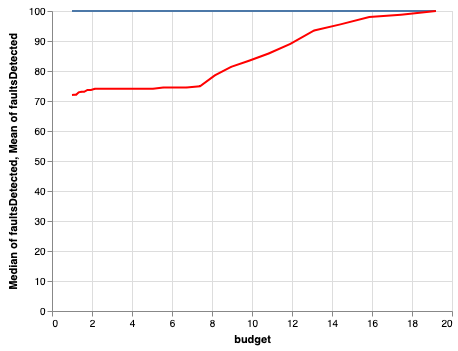

In [83]:
alt.Chart(dz).mark_line().encode(x='budget', y='median(faultsDetected)') + \
alt.Chart(dz).mark_line(color='red').encode(x='budget', y='mean(faultsDetected)')